# **⭕ Lung Tumor Detection And Segmentation Notebook**



### **✅ Problem Definition & Dataset Overview:**

**`Dataset`**\
├── train\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks\
└── val\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks
- (detections, images, masks) in both trian & val should have subfolders one for each patient (subject).
- Images and masks should be corresponding to each other and named the same.
- Detections of each patient should include text files named with the scan number
- and each scan file includes a line or more of 4 numbers each (xMin, yMin, xMax, yMax)

**`Problem:`**
Building **Recognition & Detection models** for lung-cancer tumors

**`Solution:`**\
1- Apply and Train Yolo Object Detection Model.  
2- Apply and Train UNet Segmentation Model for full images.  
3- Apply and Train UNet Segmentation Model for cropped detection image.  
4- Performance of valid data and Decide which technique is the best from 2 or 3.

In [1]:
import os
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import yaml
from typing import List, Tuple
from itertools import chain
from ultralytics import YOLO
import torch
import random
import shutil
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
from data_loader import DataLoader

c:\miniconda\envs\CV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global settings for plot styling
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.bottom'] = False
plt.rcParams['ytick.major.left'] = False
plt.rcParams['axes.grid'] = False

data_loader = DataLoader()
data_loader.load_data()

The dataset consists of 256 x 256 grayscale images
[Loading Training Data  ]  Loaded [1832] Scans (1547 Cancer + 285 Healthy)
[Loading Validation Data]  Loaded [98] Scans (78 Cancer + 20 Healthy)


**`Sample Scans`**

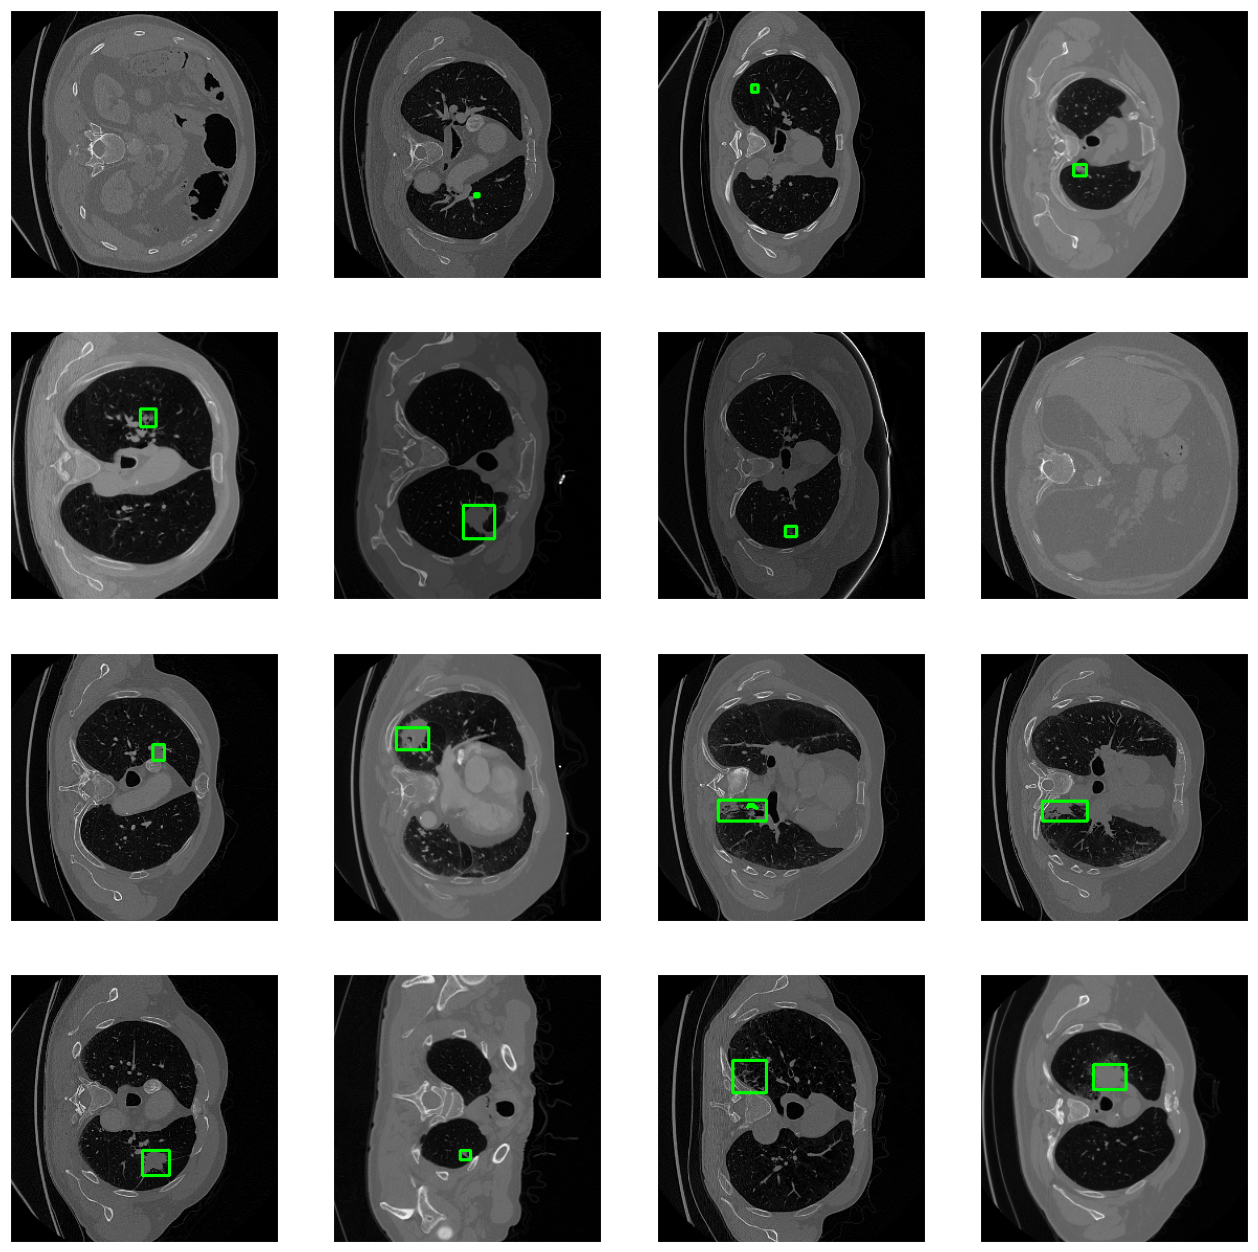

In [7]:
random_scans = data_loader.random_scans(16)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, scan in enumerate(random_scans):
    row = i // 4
    col = i % 4
    image, detections = scan
    if len(detections) <= 0:
        axes[row, col].imshow(image)
        continue
    for xmin, ymin, xmax, ymax in detections:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    axes[row, col].imshow(image)
plt.show()

# **⚡ Task1- Object Detection**

### **✅ Training Yolo Model:**

**Yolo** is an algorithm that uses convolutional neural networks for object detection.
Detection algorithm does not only predict class labels, but detects locations of objects as well.

**data.yaml** for Binary Classification You will only have two classes: one for images containing a tumor and one for images without a tumor.

In [4]:
yolo_parameters = '''
train: datset/train/images_and_detections
val: datset/val/images_and_detections
nc: 2
names: ['no_tumor', 'tumor']
'''
with open("dataset/yolo_v8_parameters.yaml", "w") as file:
    file.write(yolo_parameters)

!yolo train data=dataset/yolo_v8_parameters.yaml model=yolov8n.pt epochs=30 batch=10

^C


Ultralytics 8.3.50 🚀 Python-3.9.21 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset/yolo_v8_parameters.yaml, epochs=30, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx


  0%|          | 0.00/6.25M [00:00<?, ?B/s]
  1%|          | 72.0k/6.25M [00:00<00:09, 673kB/s]
  4%|▎         | 232k/6.25M [00:00<00:05, 1.22MB/s]
  6%|▌         | 392k/6.25M [00:00<00:04, 1.40MB/s]
  8%|▊         | 536k/6.25M [00:00<00:05, 1.13MB/s]
 10%|█         | 656k/6.25M [00:00<00:05, 1.14MB/s]
 13%|█▎        | 824k/6.25M [00:00<00:04, 1.31MB/s]
 16%|█▌        | 0.99M/6.25M [00:00<00:03, 1.50MB/s]
 18%|█▊        | 1.15M/6.25M [00:00<00:03, 1.52MB/s]
 22%|██▏       | 1.35M/6.25M [00:01<00:03, 1.64MB/s]
 24%|██▍       | 1.52M/6.25M [00:01<00:03, 1.54MB/s]
 27%|██▋       | 1.67M/6.25M [00:01<00:03, 1.46MB/s]
 30%|███       | 1.88M/6.25M [00:01<00:02, 1.60MB/s]
 33%|███▎      | 2.04M/6.25M [00:01<00:06, 678kB/s] 
 38%|███▊      | 2.37M/6.25M [00:02<00:04, 1.01MB/s]
 41%|████▏     | 2.59M/6.25M [00:02<00:03, 1.20MB/s]
 45%|████▍     | 2.80M/6.25M [00:02<00:02, 1.40MB/s]
 48%|████▊     | 3.01M/6.25M [00:02<00:02, 1.52MB/s]
 51%|█████     | 3.20M/6.25M [00:02<00:01, 1.60MB/s]
 54%|██

### **✅ Performance Yolo Model:**

`**Train Box Loss:**`\
The train box loss metric measures the difference between the predicted bounding boxes\
and the actual bounding boxes of the objects in the training data.\
A lower box loss means that the model's predicted bounding boxes more closely align with the actual bounding boxes.

`**Train Class Loss:**`\
The train class loss metric measures the difference between the predicted class probabilities and the actual class labels of the objects in the training data. A lower class loss means that the model's predicted class probabilities more closely align with the actual class labels.

`**Train DFL Loss:**`\
The train DFL (Dynamic Feature Learning) loss metric measures the difference between the predicted feature maps and the actual feature maps of the objects in the training data. A lower DFL loss means that the model's predicted feature maps more closely align with the actual feature maps.

`**Metrics Precision (B):**`\
The metrics precision (B) metric measures the proportion of true positive detections among all the predicted bounding boxes. A higher precision means that the model is better at correctly identifying true positive detections and minimizing false positives.

`**Metrics Recall (B):**`\
The metrics recall (B) metric measures the proportion of true positive detections among all the actual bounding boxes. A higher recall means that the model is better at correctly identifying all true positive detections and minimizing false negatives.

`**Metrics mAP50 (B):**`\
The metrics mAP50 (B) metric measures the mean average precision of the model across different object categories, with a 50% intersection-over-union (IoU) threshold. A higher mAP50 means that the model is better at accurately detecting and localizing objects across different categories.

`**Metrics mAP50-95 (B):**`\
The metrics mAP50-95 (B) metric measures the mean average precision of the model across different object categories, with IoU thresholds ranging from 50% to 95%. A higher mAP50-95 means that the model is better at accurately detecting and localizing objects across different categories with a wider range of IoU thresholds.

In [ ]:
df = pd.read_csv('results.csv')
df.columns = df.columns.str.strip()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axes[0, 0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axes[0, 1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axes[1, 0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axes[1, 1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axes[2, 0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axes[2, 1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axes[3, 0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axes[3, 1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axes[4, 0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axes[4, 1])
axes[0, 0].set(title='Train Box Loss')
axes[0, 1].set(title='Train Class Loss')
axes[1, 0].set(title='Train DFL Loss')
axes[1, 1].set(title='Metrics Precision (B)')
axes[2, 0].set(title='Metrics Recall (B)')
axes[2, 1].set(title='Metrics mAP50 (B)')
axes[3, 0].set(title='Metrics mAP50-95 (B)')
axes[3, 1].set(title='Validation Box Loss')
axes[4, 0].set(title='Validation Class Loss')
axes[4, 1].set(title='Validation DFL Loss')
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

### **✅ Evaluation Yolo Model:**

**mAP Metrics:**
Mean Average Precision (mAP) is a popular evaluation metric in object detection, including the YOLO model. It is used to assess the accuracy of an object detection model by measuring how well it can detect objects in an image, as well as the precision of those detections. mAP takes into account both the number of correctly identified objects and the quality of the detections, which means that it is a robust metric for assessing the performance of an object detection model.

In YOLO, mAP is particularly important because it measures the accuracy of the model in detecting objects of interest. The higher the mAP, the better the model is at identifying objects in an image.


In [ ]:
# Load the best model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Evaluate the model on the validation set
metrics = model.val()

# Print the evaluation metrics
print(metrics)

In [ ]:
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# Reading the confusion matrix image file
img = mpimg.imread('/content/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

### **✅ Testing Yolo Model:**

In [ ]:
# Load the trained YOLO model (replace with the actual path to your model)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# List of image paths to test (replace with your actual test image paths)
image_paths = ['/content/LungTumorDetectionAndSegmentation/train/images/Subject_0/304.png', '/content/LungTumorDetectionAndSegmentation/train/images/Subject_0/310.png']

# Perform inference on the images
predictions = model.predict(image_paths, conf=0.25)

# Visualizing and optionally saving the results
for img_path, pred in zip(image_paths, predictions):
    img = cv2.imread(img_path)

    # Extract the bounding boxes and labels from the predictions
    boxes = pred.boxes
    detections = pred.names

    # Draw the bounding boxes and labels on the image
    for box, det in zip(boxes, detections):
        x1, y1, x2, y2 = box.xyxy[0]
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Green box
        cv2.putText(img, det, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert the image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with predicted bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    # Optionally, save the image with predictions
    output_path = '/content/test_output/predicted_image.png'  # Define the output path for saving the image
    cv2.imwrite(output_path, img)  # Save the image with bounding boxes
